#Demonstration: Aspect Based Sentiment Analysis (ABSA)

##Scenario

- An e-commerce company wants to go beyond just "positive/negative" reviews and build a fine-grained feedback system that analyzes what customers actually feel about specific product aspects like battery, camera, price, etc.

- This is essential because:

    - A product might have great performance but a poor battery — overall sentiment isn't enough.



##Load the Dataset

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("synthetic_absa_dataset.csv")
df.head()

,review,aspect,sentiment
0,The camera is terrible.,camera,negative
1,I'm disappointed with the price.,price,negative
2,The performance is neither good nor bad.,performance,neutral
3,Excellent design and worth the price.,design,positive
4,Nothing special about the screen.,screen,neutral


##Visualize Aspect-Sentiment Distribution

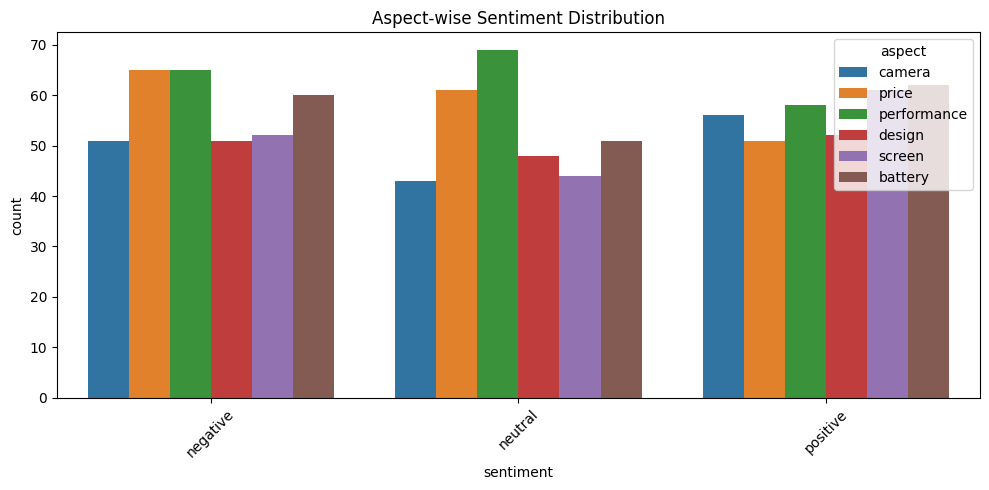

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='sentiment', hue='aspect')
plt.title("Aspect-wise Sentiment Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##Prepare Text Pairs for Model Input

In [3]:
df['input_pair'] = df.apply(lambda x: f"What is the sentiment about the {x['aspect']}? [SEP] {x['review']}", axis=1)
df[['input_pair', 'sentiment']].head()

,input_pair,sentiment
0,What is the sentiment about the camera? [SEP] ...,negative
1,What is the sentiment about the price? [SEP] I...,negative
2,What is the sentiment about the performance? [...,neutral
3,What is the sentiment about the design? [SEP] ...,positive
4,What is the sentiment about the screen? [SEP] ...,neutral


##Encode Sentiment Labels

In [4]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label'] = le.fit_transform(df['sentiment'])  # 0-negative, 1-neutral, 2-positive
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
print(label_map)

{'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}


##Split Data for Training

In [5]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['input_pair'], df['label'], test_size=0.2, random_state=42
)

##Tokenize Using BERT

- Add hugging face token in Colab Secret

In [6]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=64)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=64)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

##Create Dataset Format for Model

In [7]:
import torch

class ABSADataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {'labels': torch.tensor(self.labels[idx])}

    def __len__(self):
        return len(self.labels)

train_dataset = ABSADataset(train_encodings, train_labels.tolist())
test_dataset = ABSADataset(test_encodings, test_labels.tolist())

##Train a BERT Model for ABSA

In [10]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    save_strategy="no",
    logging_dir="./logs",
    logging_steps=10,
    report_to="none" # Disable reporting to Weights & Biases
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.021800,0.009402
2,0.004600,0.003376


TrainOutput(global_step=100, training_loss=0.23798080932348967, metrics={'train_runtime': 454.2672, 'train_samples_per_second': 3.522, 'train_steps_per_second': 0.22, 'total_flos': 15622359177600.0, 'train_loss': 0.23798080932348967, 'epoch': 2.0})

##Inference Example

In [12]:
def infer_aspect_sentiment(aspect, sentence):
    input_text = f"What is the sentiment about the {aspect}? [SEP] {sentence}"
    tokens = tokenizer(input_text, return_tensors='pt', truncation=True, padding=True)
    outputs = model(**tokens)
    prediction = torch.argmax(outputs.logits, dim=1).item()
    return le.inverse_transform([prediction])[0]

# Try this
infer_aspect_sentiment("battery", "The battery life is extremely poor.")

'negative'